# [ EXPLORATION ] 7. 뉴스 요약봇 만들기

✅텍스트 요약을 구현하는 Extractive/Abstractive 접근법에 대해 알아보고, Attentional seq2seq 구조를 활용하여 뉴스 기사 모델을 구현해 본다.

---
### - 📖목차
* ✔️7-13. 프로젝트: 뉴스기사 요약해보기
* ✔️Step 5. Summa을 이용해서 추출적 요약해보기
* ✔️노션에서의 자료를 토대로 한글 요약 모델 만들기
* ✔️네이버 뉴스 요약봇을 사용해보고, 지금 모델과 성능 비교
* ✔️회고 및 결론
* ✔️Reference(참고자료)

<br>



## ✔️7-13. 프로젝트: 뉴스기사 요약해보기
---
### Step 1. 데이터 수집하기


In [3]:
# 모듈 로드
import nltk
nltk.download('stopwords')

# 빠른 처리를 위한 멀티 프로세싱
import multiprocessing as mp   
from multiprocessing import Pool

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from functools import partial  # partial은 불필요한 함수 반복을 줄여준다
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

# 모델 관련 모듈들
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention

# 경고 무시
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# 데이터 불러오기(코랩 환경이라 google 마운트를 씁니다)
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 파일 경로 확인(전체)
!ls '/content/gdrive/MyDrive/aiffel/ex_07/' #ver_05까지 있는 상태

news_summary_more.csv  Reviews.csv


In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/aiffel/ex_07/news_summary_more.csv", encoding='iso-8859-1')
print('- 전체 샘플수 :', (len(data)))

- 전체 샘플수 : 98401


In [ ]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...



<br>

### Step 2. 데이터 전처리하기(추상적 요약)
-----
#### - 데이터 전처리하기 (1) 데이터 정리하기

In [ ]:
# 중복샘플 데이터 제거
print('- Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('- headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

- Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
- headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [ ]:
# 데이터 프레임에 NULL값 있는지 확인
print(data.isnull().sum()) 

headlines    0
text         0
dtype: int64


In [ ]:
# 앞서 중복된 샘플들 Null값까지 점검한 뒤의 데이터를 확인
data.dropna(axis=0, inplace=True)
print('- 전체 샘플수 :', (len(data)))

- 전체 샘플수 : 98401


* 중복을 제외하고 따로 Null 값은 없는걸로 확인한 뒤, 전체 샘플수 까지 체크 완료된 상태

In [ ]:
# 문장에 대한 전처리 1. 정규화 사전 수, 불용어 갯수 체크

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

정규화 사전의 수:  120
불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', '

In [ ]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [ ]:
# num_cores 만큼 쪼개진 데이터를 전처리하여 반환한다.
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  # 컴퓨터의 코어 수를 구하기
  num_cores = mp.cpu_count()  

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  return processed_data

In [ ]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print(clean_text)

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak penn talks write script fil

In [ ]:
clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요
print(clean_text)

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak penn talks write script fil

In [ ]:
clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False) # 클라우드 기준 1분정도 소요
print(clean_headlines)

['upgrad learner switches to career in ml al with salary hike'
 'delhi techie wins free food from swiggy for one year on cred'
 'new zealand end rohit sharma led india match winning streak' ...
 'the matrix film to get reboot reports'
 'snoop dogg aims gun at clown dressed as trump in new video'
 'madhesi morcha withdraws support to nepalese government']


In [ ]:
clean_headline = []

# 전체 Summary 데이터에 대한 전처리 
for s in data['headlines']:
    clean_headline.append(preprocess_sentence(s, False))

clean_headline[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [ ]:
data['text'] = clean_text
data['headlines'] = clean_headline

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [ ]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

<br>

#### - 데이터 전처리하기 (2) 훈련데이터와 테스트데이터 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09983638377659
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299651426306644


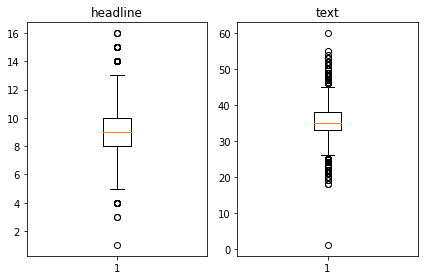

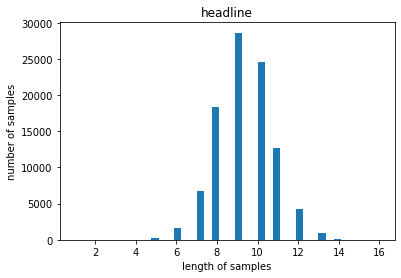

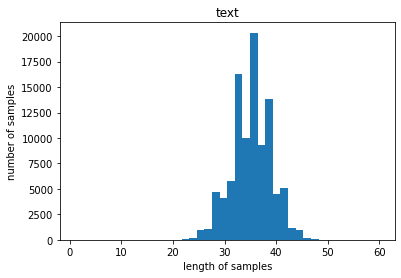

In [ ]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headline_len)))
print('요약의 최대 길이 : {}'.format(np.max(headline_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(headline_len)
plt.title('headline')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headline')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
text_max_len = 45
headlines_max_len = 13

In [ ]:
# 데이터의 몇 %에 해당하는지 계산하는 함수
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('- 전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

- 전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967784880234957
- 전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981707502972531


약 98%의 데이터가 포함된다.
이보다 긴 데이터들은 모두 제거해준다.

In [ ]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [ ]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
print('- 테스트 데이터의 수 :', n_of_val)

- 테스트 데이터의 수 : 19680


In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('- 훈련 데이터의 개수 :', len(encoder_input_train))
print('- 훈련 레이블의 개수 :', len(decoder_input_train))
print('- 테스트 데이터의 개수 :', len(encoder_input_test))
print('- 테스트 레이블의 개수 :', len(decoder_input_test))

- 훈련 데이터의 개수 : 78721
- 훈련 레이블의 개수 : 78721
- 테스트 데이터의 개수 : 19680
- 테스트 레이블의 개수 : 19680


<br>

#### - 데이터 전처리하기 (3) 정수 인코딩

In [ ]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [ ]:
threshold = 7 # 빈도 수
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('- 단어 집합(vocabulary)의 크기 :', total_cnt)
print('- 등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('- 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("- 단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("- 전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

- 단어 집합(vocabulary)의 크기 : 69609
- 등장 빈도가 6번 이하인 희귀 단어의 수: 47390
- 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22219
- 단어 집합에서 희귀 단어의 비율: 68.08027697567843
- 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4785469398450064


In [ ]:
# vocab 설정
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20000 정도로 제한()
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

* 2만 정도의 단어면 실생활에 쓰이는 어지간한 표현이 다 들어온다는 낭설에 힘입어 2만 으로 설정했다.( 저저번 프로젝트때 18000 정도로도 unk 떴던 기억이 있어서 그보다는 더 늘리는 게 낫다고 판단했다)

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[128, 30, 603, 16045, 15383, 127, 1462, 15, 114, 6659, 668, 1268, 471, 6, 24, 628, 15383, 337, 341, 36, 6490, 1, 5900, 8155, 4590, 6925, 1467, 15], [37, 85, 793, 4009, 1743, 2225, 158, 7, 408, 76, 564, 60, 25, 5753, 232, 772, 1572, 7286, 3289, 37, 53, 5232, 158, 17449, 2969, 3606, 3586, 273, 288, 744, 4656, 158, 114, 793, 2667], [1312, 1344, 5143, 249, 596, 6837, 1033, 12206, 1344, 3835, 4852, 4619, 3051, 395, 2596, 2683, 146, 3361, 104, 2403, 407, 6838, 379, 4, 1312, 2856, 12206, 16046, 3051]]


In [ ]:
# 앞서 한것과 똑같이 토크나이저를 정의하고 생성해준다
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [ ]:
threshold = 6 # 빈도 수
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('- 단어 집합(vocabulary)의 크기 :', total_cnt)
print('- 등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('- 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("- 단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("- 전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

- 단어 집합(vocabulary)의 크기 : 30139
- 등장 빈도가 5번 이하인 희귀 단어의 수: 19728
- 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10411
- 단어 집합에서 희귀 단어의 비율: 65.45671721025913
- 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.649068706056495


In [ ]:
# 기존 2000은 너무 적어서 단어수를 8000으로 증가
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 3, 2040, 57, 7, 224, 3929, 36], [1, 20, 83, 5, 1022, 794, 969, 3, 117, 34, 66, 4, 100], [1, 2691, 5, 10, 551, 3040, 583, 3, 802], [1, 694, 278, 112, 107, 103, 7, 342, 124], [1, 40, 26, 50, 32, 100, 419, 264]]
target
decoder  [[3, 2040, 57, 7, 224, 3929, 36, 2], [20, 83, 5, 1022, 794, 969, 3, 117, 34, 66, 4, 100, 2], [2691, 5, 10, 551, 3040, 583, 3, 802, 2], [694, 278, 112, 107, 103, 7, 342, 124, 2], [40, 26, 50, 32, 100, 419, 264, 2]]


In [ ]:
# 변환 중에 빈칸이 된 데이터들은 삭제하고 드롭시킨다
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('- 삭제할 훈련 데이터의 개수 :', len(drop_train))
print('- 삭제할 테스트 데이터의 개수 :', len(drop_test))

# 마찬가지로 drop 을 이용해서 데이터들을 제거
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('- 훈련 데이터의 개수 :', len(encoder_input_train))
print('- 훈련 레이블의 개수 :', len(decoder_input_train))
print('- 테스트 데이터의 개수 :', len(encoder_input_test))
print('- 테스트 레이블의 개수 :', len(decoder_input_test))

- 삭제할 훈련 데이터의 개수 : 1
- 삭제할 테스트 데이터의 개수 : 0
- 훈련 데이터의 개수 : 78720
- 훈련 레이블의 개수 : 78720
- 테스트 데이터의 개수 : 19680
- 테스트 레이블의 개수 : 19680


In [ ]:
# 패딩 : 동일하게 길이를 맞춰주기 위해 패딩을 넣어주는데, 뒤쪽, post로 넣는다
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

### Step 3. 어텐션 메커니즘 사용하기(추상적 요약)

In [ ]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 45, 128)      2560000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 45, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [ ]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 45, 128)      2560000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 45, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

#### - 모델 훈련하기

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 41s 95ms/step - loss: 5.0684 - val_loss: 4.6907
Epoch 2/50
308/308 [==============================] - 29s 93ms/step - loss: 4.5106 - val_loss: 4.3267
Epoch 3/50
308/308 [==============================] - 29s 94ms/step - loss: 4.1861 - val_loss: 4.0744
Epoch 4/50
308/308 [==============================] - 29s 95ms/step - loss: 3.9453 - val_loss: 3.8871
Epoch 5/50
308/308 [==============================] - 30s 96ms/step - loss: 3.7587 - val_loss: 3.7703
Epoch 6/50
308/308 [==============================] - 30s 97ms/step - loss: 3.6053 - val_loss: 3.6639
Epoch 7/50
308/308 [==============================] - 30s 98ms/step - loss: 3.4728 - val_loss: 3.5840
Epoch 8/50
308/308 [==============================] - 30s 99ms/step - loss: 3.3590 - val_loss: 3.5166
Epoch 9/50
308/308 [==============================] - 30s 98ms/step - loss: 3.2582 - val_loss: 3.4635
Epoch 10/50
308/308 [==============================] - 30s 99ms/step - loss: 3.168

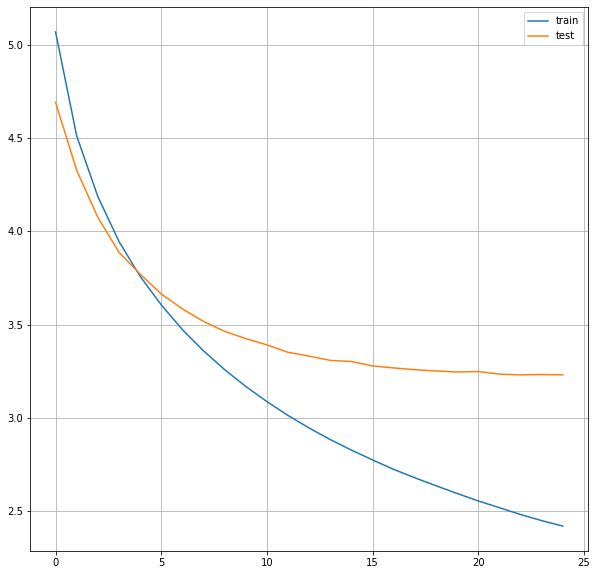

In [ ]:
# 에폭당 변화하는 loss값을 시각화
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid()
plt.show()

* 총 50번의 에폭 중에서 25 정도에서 조기종료가 되었는데, val_loss값이 3.2 정도에서 더이상 떨어지지 않아서 중단된 게 보였다. 기본적인 모델의 구조였기 때문에 뒤에 다른 모델을 구축할 경우에는 좀 더 신경을 써서 낮춰보는걸로 결정했다.

#### - 인퍼런스 모델 구현하기

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### Step 4. 실제 결과와 요약문 비교하기(추상적 요약)

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [ ]:
for i in range(50, 100):
    print("- 원문 :", seq2text(encoder_input_test[i]))
    print("- 실제 요약 :", seq2summary(decoder_input_test[i]))
    print("- 예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

- 원문 : opening fell love wife kiran rao aamir khan said divorce moment trauma phone came talked half hour put phone said feel happy added aamir said never imagine life without kiran 
- 실제 요약 : felt happy on talking to kiran after of divorce aamir 
- 예측 요약 :  my wife has been replaced irrfan on his birthday


- 원문 : american tourist carried unexploded world war ii artillery shell vienna airport asked customs officials could taken onboard flight home officials called bomb disposal unit remove dispose artillery shell woman found hiking charged negligent endangerment fined 
- 실제 요약 : tourist takes wwii to airport 
- 예측 요약 :  airport opens airport airport for hong kong airport


- 원문 : actor mukul dev series facebook posts wrote made jet airways flight five minutes take old dead cigarette found check bag sad part way amritsar receive award complete violation air regulations added mukul 
- 실제 요약 : off loaded from flight due to old cigarette mukul dev 
- 예측 요약 :  tv actress suffers onboard fa

## ✔️Step 5. Summa을 이용해서 추출적 요약해보기
---

In [ ]:
# 코랩에서는 summa를 먼저 설치해야합니다.
!pip install summa

     |████████████████████████████████| 54 kB 2.3 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=87992c4b91303b98a194ea141759aed1faffcd6ec854803654012924d5961f1a
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


In [ ]:
# 모듈 로드
import requests
from summa.summarizer import summarize

In [ ]:
# 데이터 로드 및 확인
text= pd.read_csv("/content/gdrive/MyDrive/aiffel/ex_07/news_summary_more.csv", encoding='iso-8859-1')
text["text"][:10]

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
4    Speaking about the sexual harassment allegatio...
5    Pakistani singer Rahat Fateh Ali Khan has deni...
6    India recorded their lowest ODI total in New Z...
7    Weeks after ex-CBI Director Alok Verma told th...
8    Andhra Pradesh CM N Chandrababu Naidu has said...
9    Congress candidate Shafia Zubair won the Ramga...
Name: text, dtype: object

In [ ]:
# text 컬럼의 문장을 summary 컬럼으로 요약
data['summary'] = data['text'].apply(lambda x: summarize(x, ratio=0.5))

In [ ]:
data.sample(10)

,headlines,text,decoder_input,decoder_target,summary
60563,ericsson conducts first ever live demonstratio...,swedish telecommunications company ericsson fr...,sostoken ericsson conducts first ever live dem...,ericsson conducts first ever live demonstratio...,
89967,india born hinduja brothers top uk rich list w...,india born brothers srichand gopichand hinduja...,sostoken india born hinduja brothers top uk ri...,india born hinduja brothers top uk rich list w...,
3502,ft tall national flag hoisted at hyderabad sta...,national flag hoisted foot tall pole hyderabad...,sostoken ft tall national flag hoisted at hyde...,ft tall national flag hoisted at hyderabad sta...,
25377,hc asks singh brothers to disclose foreign ban...,delhi high court directed former ranbaxy promo...,sostoken hc asks singh brothers to disclose fo...,hc asks singh brothers to disclose foreign ban...,
78590,fresh us sanctions defy common sense will reta...,us house representatives approved fresh sancti...,sostoken fresh us sanctions defy common sense ...,fresh us sanctions defy common sense will reta...,
95211,vulnerable jharkhand tribals to get food deliv...,jharkhand government monday launched food post...,sostoken vulnerable jharkhand tribals to get f...,vulnerable jharkhand tribals to get food deliv...,
85912,ios will stop uber from constantly tracking us...,apple upcoming ios ipads iphones stop apps lik...,sostoken ios will stop uber from constantly tr...,ios will stop uber from constantly tracking us...,
91721,uk supermarkets face hummus shortage,england sainsbury marks spencer outlets facing...,sostoken uk supermarkets face hummus shortage,uk supermarkets face hummus shortage eostoken,
91986,woman breaks into drake home drinks pepsi and ...,woman south carolina united states arrested al...,sostoken woman breaks into drake home drinks p...,woman breaks into drake home drinks pepsi and ...,
86970,player banned from french open for forcibly ki...,maxime hamou year old french tennis player ban...,sostoken player banned from french open for fo...,player banned from french open for forcibly ki...,


In [ ]:
# ratio 0.5일때의 요약
for i in range(5):
    print("- 원문 :", text['text'][i])
    print("- 실제 요약 :", text['headlines'][i])
    print("- 추출적 요약 :", summarize(text["text"][i], ratio=0.5))
    print("\n")

- 원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
- 실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
- 추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


- 원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
- 실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
- 추출적 요약 : Users get one CRED coin per rup

In [ ]:
# ratio 1일 때의 요약
for i in range(5):
    print("- 원문 :", text['text'][i])
    print("- 실제 요약 :", text['headlines'][i])
    print("- 추출적 요약 :", summarize(text["text"][i], ratio=1))
    print("\n")

- 원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
- 실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
- 추출적 요약 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience.
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


- 원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi tech

In [ ]:
# 단어수 10일 때의 요약
for i in range(5):
    print("- 원문 :", text['text'][i])
    print("- 실제 요약 :", text['headlines'][i])
    print("- 추출적 요약 :", summarize(text["text"][i], words=10))
    print("\n")

- 원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
- 실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
- 추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


- 원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
- 실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
- 추출적 요약 : 


- 원문 : New Zealand defeated 

* 단어수가 10개일때는 추출적 요약들이 꽤 많이 빠져있는 것을 확인할 수 있었다.

In [ ]:
# 단어수 15일 때의 요약
for i in range(5):
    print("- 원문 :", text['text'][i])
    print("- 실제 요약 :", text['headlines'][i])
    print("- 추출적 요약 :", summarize(text["text"][i], words=15))
    print("\n")

- 원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
- 실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
- 추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


- 원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
- 실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
- 추출적 요약 : Users get one CRED coin per rup

In [ ]:
# 단어수 20일 때의 요약
for i in range(5):
    print("- 원문 :", text['text'][i])
    print("- 실제 요약 :", text['headlines'][i])
    print("- 추출적 요약 :", summarize(text["text"][i], words=20))
    print("\n")

- 원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
- 실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
- 추출적 요약 : The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


- 원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, 

* 단어수가 각각 15와 20일 경우에는 제법 빼곡하게 차 있는 것을 확인할 수 있으며, 이를 토대로 단어수가 요약에도 영향을 끼친다는 걸 확인할 수 있엇다. 다만 여기에서의 문장이 길기 때문에 아무래도 더 체계적일 수 밖에 없다는 인상을 줬다.

## ✔️노션에서의 자료를 토대로 한글 요약 모델 만들기
---
### Step 1. 데이터 수집하기


![20220522050816](https://user-images.githubusercontent.com/100528803/170036580-ab3f9ad8-3e54-44cb-a823-b477c541c517.png)

한번 LMS를 따라서 기본적인 모델을 만들긴 했지만, 일단 val_loss가 원하는 만큼 떨어지지 않았고 + 한글 모델도 이대로 만들어지는지 궁금했기 때문에 앞서 노션의 주소를 따라가 Ai허브에서의 자료를 써보기로 했다.

![20220522051411](https://user-images.githubusercontent.com/100528803/170036818-b5ae3ed2-f518-4497-b231-4b96e037083f.png)

일단 데이터셋은 각기 신문, 기고문, 잡지, 법원 판결문 순이었는데 영문에서도 뉴스기사가 주제였기 때문에 뉴스 기사중에서 발췌해 사용하기로 결정했다.

![20220522051709](https://user-images.githubusercontent.com/100528803/170036892-d1c7013b-1026-4683-9c5c-be5dad0106a4.png)

다만 신문기사의 경우, 수량이 30만 정도 되기 때문에 너무 많은 양을 전처리하고 모델을 돌리는 과정이 부담될거라고 생각해서 5만 정도로 자르고 모델을 만들어 돌리는 쪽으로 방향을 잡았다.( 사실 이대로 해도 모델이 얼마나 복잡하느냐에 따라 한 에폭당 15분은 족히 걸리는 수준이라서 더 적어도 될 뻔했다....)

![20220522053935](https://user-images.githubusercontent.com/100528803/170036965-5d63db47-a660-4e2b-af64-e3e0e4438fc6.png)

문서 요약의 텍스트 경우 각각 법률, 사설, 신문기사 순이었는데 중간에 잡지가 없어진 걸 확인할 수 있었다. 어차피 다른 건 제외하고 신문기사만 쓸 예정이었기 때문에 신문기사 중에서 따로 나뉘어진 train_original 을 가져와서 여기서 validation까지 같이 추출해서 쓰는 걸로 가닥을 잡았다.

In [5]:
from tqdm import tqdm # 현재 for 문이 얼마나 실행되었는지를 알려주는 라이브러리. 작업이 오래 걸릴수록 퍼센테이지가 보여서 유용하게 쓰였다
tqdm.pandas() 
import json #json 파일을 사용할 수 있게 만들어준다

In [6]:
# 파일 경로 확인(전체)
!ls '/content/gdrive/MyDrive/aiffel/ex_07/' # 여기 있는 train, test파일을 씁니다

news_summary_more.csv  Reviews.csv  train_original.json  valid_original.json


In [155]:
# json 파일 불러오기
with open("/content/gdrive/MyDrive/aiffel/ex_07/train_original.json") as f:
  json_data = json.load(f)
documents = json_data["documents"]

In [156]:
data = pd.DataFrame(columns=['headlines','text','content'])

for document in tqdm(documents[:50000]): # 30만개의 기사를 다 쓸 수는 없어서 5만개만 가져오기로 결정
    stc_list = []
    
    for j in document['text'][2:]:
        if j == [] : continue
        stc_list.append(j[0]["sentence"])            
    data = data.append(pd.DataFrame([[document['title'],document['abstractive'][0],stc_list]], columns=['headlines','text','content']), ignore_index=True)

100%|██████████| 50000/50000 [01:58<00:00, 422.27it/s]


In [15]:
# 가져온 데이터는 본래 headlins, text, content의 3가지 컬럼
data.head()

,headlines,text,content
0,"논 타작물 재배, 2월 말까지 신청하세요",전라남도가 쌀 과잉문제를 근본적으로 해결하기 위해 올해부터 벼를 심었던 논에 벼 대...,[전라남도가 쌀 과잉문제를 근본적으로 해결하기 위해 올해부터 시행하는 쌀 생산조정제...
1,"여수시, 컬러빌리지 마무리...‘색채와 빛’도시 완성",여수시는 컬러빌리지 사업에 8억원을 투입하여 ‘색채와 빛’ 도시를 완성하여 고소천사...,[여수시는 원도심 일대에서 추진된 컬러빌리지 사업을 지난해 말 마무리하며 색채와 빛...
2,“새해 정기 받고 올해는 반드시 일내자!”,전남드래곤즈 임직원과 선수단이 4일 구봉산 정상에 올라 일출을 보며 2018년 구단...,[전남드래곤즈(사장 신승재)는 지난 4일 구봉산 해맞이 행사를 통해 새해 각오를 다...
3,"농업인 역량 강화, 새해 실용교육 실시","광양시는 농업인들의 경쟁력을 높이고, 소득안정을 위해 매실·감·참다래 등 지역특화작...",[광양시는 오는 11일부터 24일까지 농업인교육관과 읍면동 회의실에서 농업인 105...
4,타이완 크루즈관광객 4천여명‘전남’온다,올해 4월과 6월 두 차례에 걸쳐 타이완의 크루즈 관광객 4000여명이 여수에 입항...,"[타이완의 크루즈관광객 4000여명이 올해 두 차례에 걸쳐 여수에 입항한다., 전라..."


In [157]:
# 그 중에서 위에서처럼 동일한 전처리를 하려면 똑같이 headlins와 text를 빼야 가능하기 때문에 필요한 부분만 추출
data = data[['headlines', 'text']]

In [158]:
data # 해서 headlines 와 text가 동일하게 나온 상태

,headlines,text
0,"논 타작물 재배, 2월 말까지 신청하세요",전라남도가 쌀 과잉문제를 근본적으로 해결하기 위해 올해부터 벼를 심었던 논에 벼 대...
1,"여수시, 컬러빌리지 마무리...‘색채와 빛’도시 완성",여수시는 컬러빌리지 사업에 8억원을 투입하여 ‘색채와 빛’ 도시를 완성하여 고소천사...
2,“새해 정기 받고 올해는 반드시 일내자!”,전남드래곤즈 임직원과 선수단이 4일 구봉산 정상에 올라 일출을 보며 2018년 구단...
3,"농업인 역량 강화, 새해 실용교육 실시","광양시는 농업인들의 경쟁력을 높이고, 소득안정을 위해 매실·감·참다래 등 지역특화작..."
4,타이완 크루즈관광객 4천여명‘전남’온다,올해 4월과 6월 두 차례에 걸쳐 타이완의 크루즈 관광객 4000여명이 여수에 입항...
...,...,...
49995,자유한국당 경대수 의원 '혁신도시 활성화 지원법안' 대표발의,자유한국당 경대수 의원은 혁신도시가 준공된 지 수 년이 지났으나 혁신도시의 정주여건...
49996,공주 '치매안심마을' 운영... 치매 안전망 구축,공주시는 치매환자가 안심하고 생활할 수 있도록 '치매안심마을' 5곳을 선별해 운영하...
49997,"청양군, 일손부족 농가에 벼 밀묘소식 재배가 '최고'",청양군농업기술센터가 14일 노동력과 생산비용을 절감하기 위한 벼 밀묘소식 재배법 시...
49998,"다비치안경 금왕점, 음성시니어클럽 노노케어 참여자·수혜자 난청 및 노안 검사 관리",14일 음성시니어클럽은 노노케어 참여자와 수혜자 4명에게 '노인성 난청 검사 및 노...


In [159]:
# 전체 샘플수는 앞서 30만개에서 앞에만 추출해 받아낸 5만개 데이터로 진행
print('- 전체 샘플수 :', (len(data)))

- 전체 샘플수 : 50000



<br>

### Step 2. 데이터 전처리하기(추상적 요약)
-----
#### - 데이터 전처리하기 (1) 데이터 정리하기

In [160]:
# 중복샘플 데이터 제거
print('- Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('- headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

- Text 열에서 중복을 배제한 유일한 샘플의 수 : 49997
- headlines 열에서 중복을 배제한 유일한 샘플의 수 : 50000


In [161]:
# 데이터 프레임에 NULL값 있는지 확인
print(data.isnull().sum()) 

headlines    0
text         0
dtype: int64


In [35]:
# 위의 작업에서 content를 제거하는 과정이 꼬여 copy를 안하고 dropna를 할 경우 데이터 프레임상으로의 오류가 뜨기 때문에 카피로 한번 복사
data = data.copy() 

# 앞서 중복된 샘플들 Null값까지 점검한 뒤의 데이터를 확인(사실 값은 같다)
data.dropna(axis=0, inplace=True)
print('- 전체 샘플수 :', (len(data)))

- 전체 샘플수 : 50000


In [136]:
# 한글 불용어 100개 정도 걸러내기 
stopword = pd.read_csv("/content/gdrive/MyDrive/aiffel/ex_07/한국어불용어100.txt", sep = "\t", encoding = "utf-8", header=None)
stopword.loc[100] = ['기자', 'VX', 0.000483]
stop_words =  set(stopword[0])

print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 95
{'여자', '중', '크', '말하', '다시', '어떤', '정도', '수', '그녀', '다른', '같', '지금', '기자', '점', '있', '속', '시간', '잘', '이렇', '앞', '그', '못하', '일', '생각하', '번', '개', '원', '지', '더', '사람', '이', '월', '않', '받', '아니', '통하', '하나', '씨', '그리고', '때', '많', '자신', '그런', '오', '어떻', '시키', '가', '살', '소리', '집', '나오', '좋', '만들', '두', '보이', '보', '하', '명', '그러나', '전', '대하', '모르', '말', '사실', '등', '적', '또', '그러', '위하', '주', '생각', '우리', '그것', '가지', '좀', '데', '한', '따르', '경우', '문제', '내', '나', '안', '이런', '년', '알', '싶', '놓', '그렇', '되', '들', '없', '때문', '것', '사회'}


* 한국 불용어는 아래 사이트의 텍스트 파일을 이용했습니다.

https://bab2min.tistory.com/544

In [137]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = re.sub("[.,!?\"':;~()]", " ", sentence) # 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub("r'[^ ㄱ-ㅣ가-힣A-Za-z]", " ", sentence) # 한글 외 문자(숫자, 특수문자 등) 공백으로 변환
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [41]:
# num_cores 만큼 쪼개진 데이터를 전처리하여 반환한다.
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):  
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구하기

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  return processed_data

In [138]:
clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요
print(clean_text)

['전라남도가 과잉문제를 근본적으로 해결하기 위해 올해부터 벼를 심었던 논에 대신 사료작물이나 다른 작물을 심으면 벼와의 일정 소득차를 보전해주는 생산조정제 적극적으로 시행하기로 하고 오는 22일부터 2월 28일까지 농지 소재지 읍면동사무소에서 신청받는다'
 '여수시는 컬러빌리지 사업에 8억원을 투입하여 ‘색채와 빛’ 도시를 완성하여 고소천사벽화마을과 자산마을은 알록달록 색깔 옷을 입었고 사업 시행과 준공 과정에서도 주민들의 참여를 유도해 경관사업의 좋은 사례를 만들었다'
 '전남드래곤즈 임직원과 선수단이 4일 구봉산 정상에 올라 일출을 보며 2018년 구단 목표 달성을 위한 새해 각오를 다졌다' ...
 '청양군농업기술센터가 14일 노동력과 생산비용을 절감하기 위한 밀묘소식 재배법 시연회를 가졌으며 해당 방법을 사용할 경우 노동력과 생산비를 70%정도 절감할 있다고 하였다'
 '14일 음성시니어클럽은 노노케어 참여자와 수혜자 4명에게 노인성 난청 검사 노안 검사 다비치 보청기-안경 금왕점에서 실시했다고 밝힌 가운데 다비치 보청기-안경 금왕점은 연말까지 노노케어 참여자와 수혜자 800여 명을 검사를 뜻을 밝혔다'
 '음성 극동대학교 평생교육원은 음성읍 읍내 2리에서 2019년 농촌재능나눔 지자체 활동지원사업으로 음성군으로부터 위임받은 재능기부 활동인 방방곡곡 찾아가는 청년들의 재능나눔 1회차 활동을 10개 마을을 대상으로 진행했다고 14일 밝혔다']


In [162]:
clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False) # 클라우드 기준 1분정도 소요
print(clean_headlines)

['타작물 재배 2월 말까지 신청하세요' '여수시 컬러빌리지 마무리 ‘색채와 빛’도시 완성'
 '“새해 정기 받고 올해는 반드시 일내자' ... '청양군 일손부족 농가에 밀묘소식 재배가 최고'
 '다비치안경 금왕점 음성시니어클럽 노노케어 참여자·수혜자 난청 노안 검사 관리'
 '음성 극동대학교 평생교육원 2019년 농촌재능나눔 지자체 활동지원사업 시작']


In [163]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [147]:
# 결측치를 확인하는데... headline에서만 비는게 2개나 있다
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [164]:
# 데이터 확인
data[data.headlines.isnull()]

,headlines,text
9459,NaN,가을 태풍으로 배추가 썩고 상품성이 떨어져서 배추밭을 갈아엎는 농민이 늘고 있는데 ...
42172,NaN,본격적인 여름 휴가철이 다가오면서 필라 라구아나 괌정부관광청장은 한국인 관광객을 유...


In [165]:
# 결측치가 사라진 것을 확인
data = data.dropna()
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [166]:
data

,headlines,text
0,타작물 재배 2월 말까지 신청하세요,전라남도가 과잉문제를 근본적으로 해결하기 위해 올해부터 벼를 심었던 논에 대신 사료...
1,여수시 컬러빌리지 마무리 ‘색채와 빛’도시 완성,여수시는 컬러빌리지 사업에 8억원을 투입하여 ‘색채와 빛’ 도시를 완성하여 고소천사...
2,“새해 정기 받고 올해는 반드시 일내자,전남드래곤즈 임직원과 선수단이 4일 구봉산 정상에 올라 일출을 보며 2018년 구단...
3,농업인 역량 강화 새해 실용교육 실시,광양시는 농업인들의 경쟁력을 높이고 소득안정을 위해 매실·감·참다래 지역특화작목 중...
4,타이완 크루즈관광객 4천여명‘전남’온다,올해 4월과 6월 차례에 걸쳐 타이완의 크루즈 관광객 4000여명이 여수에 입항해 ...
...,...,...
49995,자유한국당 경대수 의원 혁신도시 활성화 지원법안 대표발의,자유한국당 경대수 의원은 혁신도시가 준공된 년이 지났으나 혁신도시의 정주여건 전반이...
49996,공주 치매안심마을 운영 치매 안전망 구축,공주시는 치매환자가 안심하고 생활할 있도록 치매안심마을 5곳을 선별해 운영하는 치매...
49997,청양군 일손부족 농가에 밀묘소식 재배가 최고,청양군농업기술센터가 14일 노동력과 생산비용을 절감하기 위한 밀묘소식 재배법 시연회...
49998,다비치안경 금왕점 음성시니어클럽 노노케어 참여자·수혜자 난청 노안 검사 관리,14일 음성시니어클럽은 노노케어 참여자와 수혜자 4명에게 노인성 난청 검사 노안 검...


* 앞서 영문과 동일한 데이터 전처리를 진행할 생각이었기 때문에 가장 숫자가 비슷한 요약문을 [ text ]로, 제목을 [ headlines ]로 각기 빼서 정렬해줬다. 비록 언어는 다르지만 같은 환경의 자료를 넣어줘야 더 객관적인 판단과 깔끔한 코드가 가능할 것 같아서 이와 같이 데이터를 정렬한 뒤에 다음 작업을 시작했다.

<br>

#### - 데이터 전처리하기 (2) 훈련데이터와 테스트데이터 나누기

텍스트의 최소 길이 : 3
텍스트의 최대 길이 : 90
텍스트의 평균 길이 : 25.320532821312852
요약의 최소 길이 : 1
요약의 최대 길이 : 498
요약의 평균 길이 : 6.124804992199688


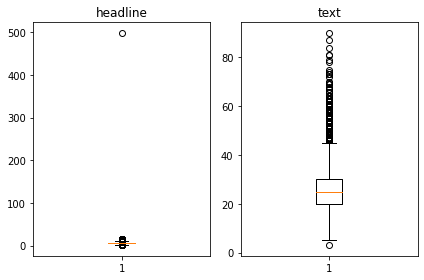

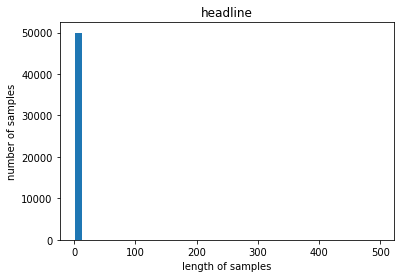

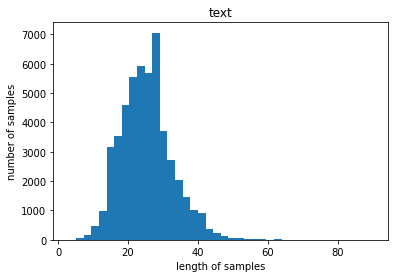

In [167]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headline_len)))
print('요약의 최대 길이 : {}'.format(np.max(headline_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(headline_len)
plt.title('headline')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headline')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [168]:
text_max_len = 45 
headlines_max_len = 13

* 처음엔 뭔가 값이 잘못 잡힌게 아닌가 하고 찬찬히 봤는데... Headline 같은 경우 중간에 498짜리가 하나 있었다. 전처리가 끝난 뒤에는 제대로 나오는지 체크하기로 했다. 글자수 시각화를 미루어보다 45 내외면 text의 대부분 값을 받을 수 있고, 앞서 498 하나가 나왔던 headlines의 경우 영어와 마찬가지로 13자리면 충분히 커버가 가능할 것 같아 동일하게 결정했다.

In [169]:
# 데이터를 정렬해서 몇번째에 값이 있는지를 도출
print (data.headlines.str.len().sort_values())

40345       2
26676       2
28201       2
22358       2
7533        2
         ... 
34827      60
11890      61
13364      61
12189      63
34876    2434
Name: headlines, Length: 49998, dtype: int64


* 마지막에 2434 자라는 엄청난 수를 자랑하는 데이터가 있는걸 확인하고 해당 데이터를 체크해본 뒤에, 제거하기로 결정했다.

In [170]:
# 해당 데이터 확인
data.loc[[34876]]

,headlines,text
34876,송전선로 건설 면민 하나 막아내자 석문면 송전선로 건설 관련 대책위 출범 \r\n호...,당진시의회 의장단의 업무추진비 정산이 시민사회를 대상으로 하는 보조금 정산에 비해 ...


In [171]:
# 해당 열을 제거한 뒤에 데이터가 1개 줄어든 것을 확인
data = data.drop(index=34876)
print('- 전체 샘플수 :', (len(data)))

- 전체 샘플수 : 49997


텍스트의 최소 길이 : 3
텍스트의 최대 길이 : 90
텍스트의 평균 길이 : 25.320279216753004
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 6.114966898013881


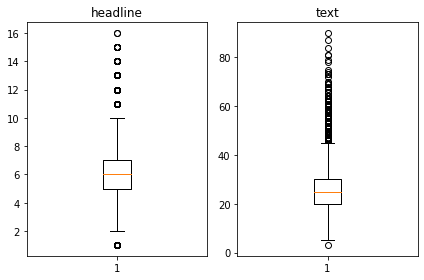

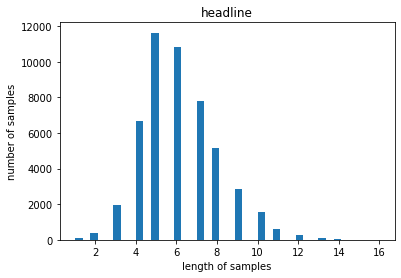

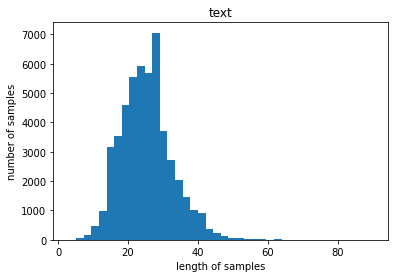

In [172]:
# 다시 동일한 코드로 제대로 아웃라이어가 제거됐는지를 체크
text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headline_len)))
print('요약의 최대 길이 : {}'.format(np.max(headline_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(headline_len)
plt.title('headline')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headline')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* 이제 텍스트와 헤드라인의 제대로 된 값이 시각화에서도 도출되어 보이기 시작했다. 헤드라인의 경우 자세히 보면 6자 정도가 가장 많았고, 길면 12자 정도가 되는 걸 확인할 수 있었고, 텍스트의 경우에 40자 안팎이면 거의 대다수를 다 포용할 수 있는 걸로 다시 점검해 볼 수 있었다.

In [173]:
# 데이터의 몇 %에 해당하는지 계산하는 함수
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('- 전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

- 전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.99101946116767
- 전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9991199471968318


In [174]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가 후, 이보다 더 긴 데이터들은 제거하기로 결정
data = data.copy()
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')

data.head()

,headlines,text,decoder_input,decoder_target
0,타작물 재배 2월 말까지 신청하세요,전라남도가 과잉문제를 근본적으로 해결하기 위해 올해부터 벼를 심었던 논에 대신 사료...,sostoken 타작물 재배 2월 말까지 신청하세요,타작물 재배 2월 말까지 신청하세요 eostoken
1,여수시 컬러빌리지 마무리 ‘색채와 빛’도시 완성,여수시는 컬러빌리지 사업에 8억원을 투입하여 ‘색채와 빛’ 도시를 완성하여 고소천사...,sostoken 여수시 컬러빌리지 마무리 ‘색채와 빛’도시 완성,여수시 컬러빌리지 마무리 ‘색채와 빛’도시 완성 eostoken
2,“새해 정기 받고 올해는 반드시 일내자,전남드래곤즈 임직원과 선수단이 4일 구봉산 정상에 올라 일출을 보며 2018년 구단...,sostoken “새해 정기 받고 올해는 반드시 일내자,“새해 정기 받고 올해는 반드시 일내자 eostoken
3,농업인 역량 강화 새해 실용교육 실시,광양시는 농업인들의 경쟁력을 높이고 소득안정을 위해 매실·감·참다래 지역특화작목 중...,sostoken 농업인 역량 강화 새해 실용교육 실시,농업인 역량 강화 새해 실용교육 실시 eostoken
4,타이완 크루즈관광객 4천여명‘전남’온다,올해 4월과 6월 차례에 걸쳐 타이완의 크루즈 관광객 4000여명이 여수에 입항해 ...,sostoken 타이완 크루즈관광객 4천여명‘전남’온다,타이완 크루즈관광객 4천여명‘전남’온다 eostoken


In [175]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
print('- 테스트 데이터의 수 :', n_of_val)

- 테스트 데이터의 수 : 9999


In [176]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('- 훈련 데이터의 개수 :', len(encoder_input_train))
print('- 훈련 레이블의 개수 :', len(decoder_input_train))
print('- 테스트 데이터의 개수 :', len(encoder_input_test))
print('- 테스트 레이블의 개수 :', len(decoder_input_test))

- 훈련 데이터의 개수 : 39998
- 훈련 레이블의 개수 : 39998
- 테스트 데이터의 개수 : 9999
- 테스트 레이블의 개수 : 9999


* 각기 데이터들이 온전하게 나뉘어진걸 확인할 수 있었고, 이제부터는 본격적으로 임베딩 작업에 들어간다.

<br>

#### - 데이터 전처리하기 (3) 정수 인코딩

In [91]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [92]:
threshold = 7 # 빈도 수
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('- 단어 집합(vocabulary)의 크기 :', total_cnt)
print('- 등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('- 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("- 단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("- 전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

- 단어 집합(vocabulary)의 크기 : 240687
- 등장 빈도가 6번 이하인 희귀 단어의 수: 220902
- 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19785
- 단어 집합에서 희귀 단어의 비율: 91.77978037866606
- 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 32.73217192055976


* 영어에서와는 달리 3~4퍼센트 남짓에 불과하던 희귀 단어의 비율이 꽤 높게 나오는 것을 확인할 수 있었다. 확실히 한글의 특성상 희귀단어를 최대한 줄이면서 적당한 값을 찾아야겠다는 생각이 들었다.

In [93]:
threshold = 2 # 빈도 수
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('- 단어 집합(vocabulary)의 크기 :', total_cnt)
print('- 등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('- 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("- 단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("- 전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

- 단어 집합(vocabulary)의 크기 : 240687
- 등장 빈도가 1번 이하인 희귀 단어의 수: 163074
- 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 77613
- 단어 집합에서 희귀 단어의 비율: 67.75355544753144
- 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 16.03693705654143


* 희귀 단어를 제외시킬 경우 단어 집합의 크기는 7만, 단어 집합에서 희귀 단어 비율은 67퍼센트, 1번 이하의 희귀단어는 16만이기 때문에 타협을 해야했다.

In [94]:
# vocab 설정
src_vocab = 80000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 80000 정도로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [95]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[292, 6890, 47663, 1361, 273, 1577, 604, 15460, 655, 10830, 77614, 10048, 47664, 4, 22, 77615, 304, 3045, 77616, 77617, 5662, 5663, 264, 77618], [28, 7246, 77619, 23046, 2903, 1545, 77620, 7246, 6891, 47665, 47666, 77621, 2037, 34864, 8719, 550, 47667, 5917, 77622, 1180, 77623, 172, 1890, 14011, 34865], [4420, 78, 77624, 10831, 3294, 4978, 27683, 177, 6523, 14012, 51, 27683, 767, 1127, 77625, 47668, 134, 77626, 7689, 77627, 202, 3998, 2714, 31]]


In [96]:
# 앞서 한것과 똑같이 디코더의 토크나이저를 정의하고 생성
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [98]:
threshold = 2 # 빈도 수
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('- 단어 집합(vocabulary)의 크기 :', total_cnt)
print('- 등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('- 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("- 단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("- 전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

- 단어 집합(vocabulary)의 크기 : 88688
- 등장 빈도가 1번 이하인 희귀 단어의 수: 63947
- 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24741
- 단어 집합에서 희귀 단어의 비율: 72.10332852246076
- 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 22.270165980594967


In [99]:
# 한글은 희귀단어의 빈도수가 더 컸기 때문에 단어수를 30000으로 증가
tar_vocab = 30000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 24743, 2879, 1302, 24744, 10130, 24745, 550, 3544], [1, 24746, 24747, 14354, 837, 6292, 4546, 1814, 10131], [1, 309, 10132, 3545, 35, 24748, 6293, 7756, 331], [1, 13, 24749, 5294, 242, 6294, 24750], [1, 24751, 809, 5295, 7757, 407, 24752]]
target
decoder  [[24743, 2879, 1302, 24744, 10130, 24745, 550, 3544, 2], [24746, 24747, 14354, 837, 6292, 4546, 1814, 10131, 2], [309, 10132, 3545, 35, 24748, 6293, 7756, 331, 2], [13, 24749, 5294, 242, 6294, 24750, 2], [24751, 809, 5295, 7757, 407, 24752, 2]]


In [100]:
# 변환 중에 빈칸이 된 데이터들은 삭제하고 드롭시킨다
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('- 삭제할 훈련 데이터의 개수 :', len(drop_train))
print('- 삭제할 테스트 데이터의 개수 :', len(drop_test))

# 마찬가지로 drop 을 이용해서 데이터들을 제거
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('- 훈련 데이터의 개수 :', len(encoder_input_train))
print('- 훈련 레이블의 개수 :', len(decoder_input_train))
print('- 테스트 데이터의 개수 :', len(encoder_input_test))
print('- 테스트 레이블의 개수 :', len(decoder_input_test))

- 삭제할 훈련 데이터의 개수 : 298
- 삭제할 테스트 데이터의 개수 : 148
- 훈련 데이터의 개수 : 39700
- 훈련 레이블의 개수 : 39700
- 테스트 데이터의 개수 : 9851
- 테스트 레이블의 개수 : 9851


In [101]:
# 패딩 : 동일하게 길이를 맞춰주기 위해 패딩을 넣어주는데, 뒤쪽, post로 넣는다
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

* post의 경우 뒤쪽에 패딩이 들어가기 때문에, 앞서 영문에서처럼 똑같이 뒤에서 패딩을 넣어줌으로서 각기 문장의 길이를 맞춰줬다.

<br>

### Step 3. 어텐션 메커니즘 사용하기(추상적 요약)

In [103]:
# 인코더 설계 시작
embedding_dim = 1024 # 영어 모델 돌릴때 기본값으로 좋은 결과를 못봤기 때문에 1024로 변경
hidden_size = 512 #마찬가지로 512로 변경

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [106]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [107]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 45, 1024)     81920000    ['input_2[0][0]']                
                                                                                                  
 lstm_3 (LSTM)                  [(None, 45, 512),    3147776     ['embedding_1[0][0]']            
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                              

In [108]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 45, 1024)     81920000    ['input_2[0][0]']                
                                                                                                  
 lstm_3 (LSTM)                  [(None, 45, 512),    3147776     ['embedding_1[0][0]']            
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                            

In [109]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
156/156 [==============================] - 392s 2s/step - loss: 3.7564 - val_loss: 3.0124
Epoch 2/50
156/156 [==============================] - 378s 2s/step - loss: 3.4091 - val_loss: 2.8917
Epoch 3/50
156/156 [==============================] - 377s 2s/step - loss: 3.2807 - val_loss: 2.8291
Epoch 4/50
156/156 [==============================] - 379s 2s/step - loss: 3.1431 - val_loss: 2.7856
Epoch 5/50
156/156 [==============================] - 378s 2s/step - loss: 3.0002 - val_loss: 2.7549
Epoch 6/50
156/156 [==============================] - 383s 2s/step - loss: 2.8577 - val_loss: 2.7410
Epoch 7/50
156/156 [==============================] - 383s 2s/step - loss: 2.7120 - val_loss: 2.7194
Epoch 8/50
156/156 [==============================] - 387s 2s/step - loss: 2.5661 - val_loss: 2.7209
Epoch 9/50
156/156 [==============================] - 403s 3s/step - loss: 2.4198 - val_loss: 2.7333
Epoch 9: early stopping


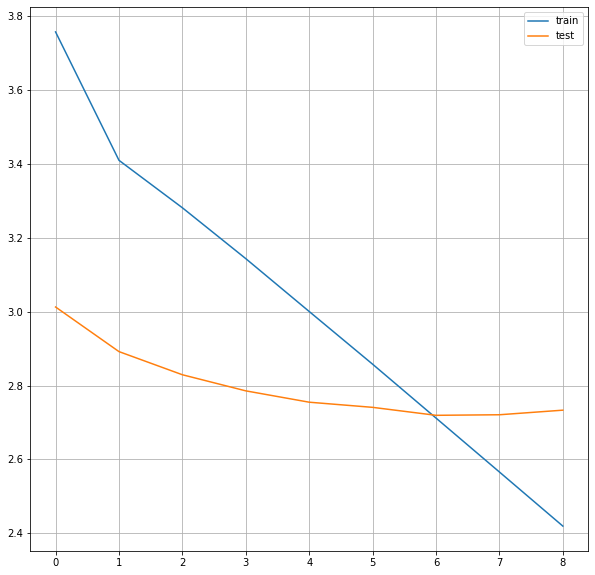

In [110]:
# 에폭당 변화하는 loss값을 시각화
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid()
plt.show()

* 50번의 에폭을 걸긴 했는데 작정하고 임베딩 사이즈 1024, 히든 레이어 사이즈를 512 정도로 넣으니 10에폭 안팎으로 정리되긴 했다. 하지만... 한 에폭당 10분 정도 걸리는 사악한 시간이랑 val_loss가 그렇게 떯어지지 않은데 대해서는 시간이 남으면 한번 더 돌려볼까 고민하게 만들었다.(1시간씩 걸리더라고요...)

#### - 인퍼런스 모델 구현하기

In [111]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [112]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [113]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [114]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### Step 4. 실제 결과와 요약문 비교하기(추상적 요약)

In [115]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [118]:
for i in range(50, 100):
    print("- 원문 :", seq2text(encoder_input_test[i]))
    print("- 실제 요약 :", seq2summary(decoder_input_test[i]))
    print("- 예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

- 원문 : 창원지법 형사1부는 공직선거법 불구속기소 경남 시장의 변호인 측과 함께 특히 유일하게 인정한 cctv 등을 돌며 진행했다 
- 실제 요약 : 법원 선거법 기소된 가져 
- 예측 요약 :  세월호 참사 5주기 5주기 5주기 학생


- 원문 : 기아자동차가 2019 광주세계수영선수권대회의 되어 대회 기간 동안 차량을 선수단에 제공한다 
- 실제 요약 : 강화 기아차 광주수영대회 공식 후원 
- 예측 요약 :  2019 대한민국


- 원문 : 대구시가 2014년부터 시작된 해외 봉사 활동의 6번째 대상지로 베트남 방문해 지난 7일부터 11일까지 5개 단체 4천여 명의 환자를 치료하고 검진을 수행했다 
- 실제 요약 : 메디시티 대구 6년째 해외 의료봉사 
- 예측 요약 :  대구시 전국 지자체


- 원문 : 작년 그랑프리 동메달을 받은 이번 선수권 대회에서 한국 남자 최초 싱글 메달과 우승을 노린다 
- 실제 요약 : 도전 
- 예측 요약 :  광주 fc


- 원문 : 무대 콘서트’가 오는 8일 오후 7시 30분 광주문화예술회관 소극장에서 열려 이날 공연은 위한 무대를 지난 2009년 창단하여 지금까지 연주 활동을 거쳤다 
- 실제 요약 : 8일 열정 콘서트 문예회관 
- 예측 요약 :  호남대 초청 특강


- 원문 : 곽대훈 위원장이 다음달 대구시당 위원장 임기가 끝나는 가운데 대구 지역 대다수의 의원들이 위원장이 내년 총선에 의견을 내비치며 표하고 있어 가능성이 높을 것으로 보인다 
- 실제 요약 : 곽대훈 한국당 대구시당 위원장 연임 
- 예측 요약 :  한국당 여야 4당


- 원문 : 최근 해양쓰레기 문제가 심각한 환경문제로 대두되고 어민들의 각종 문제가 발생하는 상황에 올해 11억 3500만 원을 투입해 도서 중심으로 쓰레기를 우선 해양쓰레기 했다 
- 실제 요약 : 보령시 해양쓰레기 11억 투입 
- 예측 요약 :  도내


- 원문 : 9일 따르면 근로·자녀장려금 신청 대상이 증가함에 따라 신청이 급증하여 지난 1일부터 현재까지 

* 총체적으로 너무 어이가 없어서... 역시 한글은 영어랑 체계 자체가 다르기 때문에 같은 방법으로 임베딩을 하면 안된다고 판단했다. 아니 일단 모든 과정을 똑같이 맞추려고 엄청 애를 썼는데도 이정도면.... 확실히 언어는 그 형태와 요소에 따라 각각의 임베딩 과정에서도 신경을 써야했다는게 절실히 느껴지는 순간이었다.

## ✔️문제 해결 : 보다 멀쩡한 한글 문장을 생성하게 만들자
---
앞서 처음 문장의 요약에서 가장 큰 실패요인은 바로 임베딩이었다. 이에 관련해 아예 한국어 전용이 가능한 임베딩 라이브러리를 설치한 뒤에도 요약문이 별로면 깨끗하게 포기하기로 결정했다. 또한 이에 따라 너무 많은 수의 단어들이 사라지지 않게끔 보카 수를 신경쓰는 것 역시 문장의 완성도를 높이는 관건이라고 판단했다.

In [ ]:
# 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!pip install sklearn

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

In [ ]:
from konlpy.tag import Mecab
tokenizer = Mecab()

fig,ax=plt.subplots(1,2,figsize=(15,15))

doc = data['text']
doc = doc.apply(lambda sent: ' '.join(tokenizer.morphs(sent)))
top_n_bigrams=get_top_ngram(doc,2)[:20]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x,ax=ax[0]).set_title('text') 

doc = data['text'].apply(lambda tmp_list: ' '.join(tmp_list) )
doc = doc.apply(lambda sent: ' '.join(tokenizer.morphs(sent)))
top_n_bigrams=get_top_ngram(doc,2)[:20]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x,ax=ax[1]).set_title('text') 

doc = data['headlines'].apply(lambda tmp_list: ' '.join(tmp_list) )
doc = doc.apply(lambda sent: ' '.join(tokenizer.morphs(sent)))
top_n_bigrams=get_top_ngram(doc,2)[:20]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x,ax=ax[2]).set_title('headlines') 

    
fig.suptitle("Common bigrams")

In [129]:
# 한국어 임베딩을 위해서 다른 라이브러리를 가져옴
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 5.3 MB/s 
     |████████████████████████████████| 453 kB 72.3 MB/s 


In [130]:
from konlpy.tag import Okt
from tqdm import tqdm
okt = Okt()

In [177]:
# konlpy > OKT로 토크나이저 진행
encoder_input_train_tok = np.empty((1,))
for s in tqdm(encoder_input_train):
  encoder_input_train_tok = np.append(encoder_input_train_tok, okt.morphs(s), axis=0)

100%|██████████| 39998/39998 [58:05<00:00, 11.48it/s]


* 진짜 실행시간이 무지막지하게 오래걸렸다... 임베딩 과정에서 이렇게까지 시간을 잡아먹을거라고는 생각도 못했기 때문에 이때부터는 최대한 효율적으로 모델을 처리해야겠다는 생각밖에 안들었던 것 같다. 하지만 그만큼 한글 임베딩이 제대로 작용해줬으면 좋겠다는 생각이 더 간절히 들었던 기억이 난다.

In [178]:
encoder_input_train_tok

array(['1.17504e-319', '360만', '중소기업', ..., '화두', '로', '떠올랐다'],
      dtype='<U32')

In [179]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [181]:
encoder_input_train_tok.shape[0]

1859877

In [185]:
src_vocab = 50000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [187]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [190]:
threshold = 2
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('- 단어 집합(vocabulary)의 크기 :',total_cnt)
print('- 등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('- 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("- 단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("- 전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

- 단어 집합(vocabulary)의 크기 : 88768
- 등장 빈도가 1번 이하인 희귀 단어의 수: 63924
- 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24844
- 단어 집합에서 희귀 단어의 비율: 72.01243691420332
- 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 22.2554129283603


In [191]:
tar_vocab = 50000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [192]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[47687, 34875, 986, 17303, 13944, 7275, 4585, 7686, 1150, 103, 19827, 12719, 2194, 2419, 34876], [189, 1668, 47688, 15451, 6189, 8729, 1, 1416, 1669, 1389, 3, 10021, 3037, 205], [694, 262, 1845, 1137, 19828, 27621, 47689, 4952, 299, 710, 12720, 273, 15452, 23077, 1808, 7276, 11, 1341, 10022, 4012, 5401, 10777, 1613, 5402]]


In [194]:
# 패딩을 뒤에 넣어줌으로서 아까와 똑같이 진행
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

In [245]:
# 임베딩과 히든 사이즈의 값이 커지면 첫 에폭부터 확 폭이 너무 줄어서 다시 확 줄였다
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.5)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.5)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.5)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [246]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [247]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 45)]         0           []                               
                                                                                                  
 embedding_22 (Embedding)       (None, 45, 128)      6400000     ['input_26[0][0]']               
                                                                                                  
 lstm_46 (LSTM)                 [(None, 45, 256),    394240      ['embedding_22[0][0]']           
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                           

In [248]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 45)]         0           []                               
                                                                                                  
 embedding_22 (Embedding)       (None, 45, 128)      6400000     ['input_26[0][0]']               
                                                                                                  
 lstm_46 (LSTM)                 [(None, 45, 256),    394240      ['embedding_22[0][0]']           
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                           

In [249]:
# 모델 학습, 여기서도 에폭은 50이지만 val_loss를 대상으로 조기 종류를 걸어둔 상태
model.compile(optimizer='adam', loss='categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=20)

Epoch 1/20
157/157 [==============================] - 279s 2s/step - loss: 0.2750 - val_loss: 8.3613e-06
Epoch 2/20
157/157 [==============================] - 267s 2s/step - loss: 1.1155e-06 - val_loss: 6.2362e-11
Epoch 3/20
157/157 [==============================] - 268s 2s/step - loss: 2.0633e-11 - val_loss: 0.0000e+00
Epoch 4/20
157/157 [==============================] - 270s 2s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20
 86/157 [===============>..............] - ETA: 1:48 - loss: 0.0000e+00

KeyboardInterrupt: ignored

In [ ]:
# 에폭당 변화하는 loss값을 시각화
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid()
plt.show()

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [ ]:
for i in range(50, 100):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

## ✔️네이버 뉴스 요약봇을 사용해보고, 지금 모델과 성능 비교
---
### Step 1. 데이터 수집하기


## ✔️회고 및 결론
---

#### ▶️ 이번 프로젝트에서 어려웠던 점

시간과의 싸움....
다른걸 떠나서 여러가지 시도를 하기 힘들었던 시간적인 여유가 절대적으로 부족했다. 이번에는 모델 돌리는 시간이 최소 1시간 가량 걸렸기 때문에 쉽게 모델 값을 바꾸지 못해서 로스값 떨어뜨리는게 쉽지 않았다는 걸 가장 어려웠던 점으로 꼽고 싶다. 그리고 전체적인 문맥을 어떻게 해야 가다듬을 수 있을까에 대해 모델의 이해가 부족하지 않았나 진행하면서도 재차 느꼈다.

<br>

#### ▶️ 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

![20220524224225](https://user-images.githubusercontent.com/100528803/170050284-c13b7879-cfd6-45d4-a122-b8557f5b0253.png)

영어도 그랬고 영어랑 같은 임베딩을 쓴 한글 모델의 경우, 에폭값이 정말 안떨어져서 오히려 히든 레이어나 임베딩 값을 엄청나게 늘려서 진행했었다. 하지만 바로 직후 KoNLPy로 토크나이저를 교체한 뒤에는 오히려 값이 크면 금방 끝내서 로스값이 확 커지는걸 보고 여태까지는 없던 일이라서 놀랐다. 사실 지금도 좀 미스테리다........원인을 제대로 찾지 못해서 찝찝한데, 시간이 좀더 있었다면 다시 임베딩부터 다 뒤져봤을 거 같아서 아쉬움이 남는다.

<br>


#### ▶️ 루브릭 평가 지표를 맞추기 위해 시도한 것들

이번 프로젝트에서 루브릭의 기준은 아래와 같았다.

|       |                                    **< 평가문항 >**                                   |                                                              **< 상세기준 >**                                                             |
|-------|:---------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------|
| **1** | Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.<br>                                 | 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.<br>                                                        |
| **2** | 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.<br> | 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.                             |
| **3** | Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.                                    | 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다. |

### - Abstractive 요약 결과:
1. 원문 : hotel president wilson swiss city geneva houses world expensive hotel suite prices starting per night royal penthouse suite hosted heads states celebrities occupying whole top floor hotel features bedrooms fitness room piano well bulletproof windows 
- 실제 요약 : world most expensive hotel costs lakh per night 
- 예측 요약 :  dubai hotel sells for crore

= 원문에서의 실제 내용은 여러 유명인들이 묵는 비싼 호텔 스위트룸의 가격에 대한 것이었는데, 예측 요약에서는 아예 호텔을 팔아버릴 기세라 요약이 제대로 되었다고는 말하기 힘들었다. 물론 단어들은 잘 뽑아낸 것 같긴 한데 중간에 room 이 빠진건 좀 타격이 커 보인다.

<br>

2. 원문 : us jury awarded million damages family african american woman killed police armed time shot standoff wherein served warrants appearing court certain cases notably live streaming encounter police 
- 실제 요약 : crore awarded to family of us woman shot dead by police 
- 예측 요약 :  us man killed in us for not paying for cr

= 이 경우 경찰의 총에 의해 숨진 여성에 대해 가족에게 100만 달러 판결을 내린 배심원단에 대한 내용이었는데, 요약에서는 전혀 엉뚱한 예측을 던져주는 바람에 이게 대체 무슨말인지 이해하지 못했다... 꼭 학생때 이 문장에 대한 잘못된 해석을 고르라는 내용 같았다. 적어도 woman이기라도 했으면 반은 갔을 것 같은데....

<br>

### - Extractive 요약 결과:
1. 원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
- 실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
- 추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.

= 중점적인 내용은 경력지원 프로그램을 통해서 90퍼센트 급여 인상 + 데이터 과학자로 전환하는데 성공했다였는데 여기서의 추출적 요약도 upGrad’s Online Power learning을 통해 경력을 올렸다는 점을 다 꼽았기 때문에 엇비슷하게 요점을 뽑아낸 게 보인다. 물론 이 문장은 실제 원문의 맨 마지막 문장이다.

<br>

2. 원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
- 실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
- 추출적 요약 : Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.

= 여기서는 결제플랫폼에서의 혜택을 간략하게 소개해주는 페이지였는데, 실제 요약에서는 무료 음식에 관한 내용이지만, 추출적 요약의 경우 뒤 문장을 그대로 가져왔다는 점에서 앞서 본 요약이란 비슷한 맥락임을 확인했다.

둘의 결과로 미루어 볼 때, 추출적 요약의 경우 말 그대로 문장을 뽑아서 만드는데 주로 맨 문장의 요점을 가져다 쓰는걸 확인할 수 있었고, 추상적 요약의 경우 얼마나 중점 단어를 뽑아오느냐가 관건이었는데 아쉽게 한두 단어가 빠져있는 것을 확인했다.

<br>

### - 한글 추상적 요약 결과(프로토타입) :
1. 원문 : 괴산군에 따르면 이차영 군수를 비롯한 150여 명이 참석한 가운데 괴산 사랑 민·관 합동 워크숍 개최해 괴산 정신 괴산 문화를 주제로 특강을 진행하는 군민 괴산 확산에 본격적으로 나섰다 
- 실제 요약 : 괴산 확산 위한 민·관 합동 워크숍 개최 
- 예측 요약 :  고흥군 평생학습 개최

= 확실한 점 1가지는 분명 요점을 잡아내려고 노력한 건 보이는데, 그게 전혀 뜬금없는 경우가 굉장히 많았다는 점이었다. 사실 이 경우는 임베딩 자체에서 한글의 특성을 제대로 살리지 못한 결과라고 생각했기 때문에 아예 한글 전용 임베딩으로 바꾸게 만든 계기가 되었다.

![20220524215107](https://user-images.githubusercontent.com/100528803/170051215-7be2ac24-15d5-4099-970e-c167f43cf1ad.png)

정확도를 위해 추가했던건 한글에 특화된 라이브러리 추가였다.


<br>

#### ▶️ 자기 다짐

확실히 NLP는 이미지보다 힘든 영역이라고 재차 짐작하게 만들었던게, 영어에서는 어느정도 통하던 모델이 한글에서는 임베딩 하나 차이로 확 무용지물이 되는걸 보면서 결국 언어에 따라서 섬세하게 바꿔줘야 하는게 많다는 걸 실감했다. 그에 따른 각각의 라이브러리를 쓰면서 어떤 특색이 있는지도 확인해야 한다는 점도 다른 분들의 논문을 읽으면서 깨닫게 만들었다.

![20220524204634](https://user-images.githubusercontent.com/100528803/170051595-fe8099fc-f570-46b4-86ef-0c8f4972101e.png)

실제로 한글 관련 라이브러리를 찾다가 각 토크나이징 라이브러리의 장단점이나 어디에 더 효율이 좋을까를 쓴 논문이 있었다. 여기서는 최종적으로 Soynlp를 선택했기 때문에 다음에 다시 할 계기가 있다면 그때는 다른 라이브러리도 써보고 싶어졌다.

## ✔️Reference(참고자료)
---
* https://wikidocs.net/22530
* https://settlelib.tistory.com/49
* https://bab2min.tistory.com/544
* https://computer-science-student.tistory.com/306
* https://eblee-repo.tistory.com/40
* https://gocoding.tistory.com/93
* 